# Matlab code in your tf.keras.Model!

{Missing: Lead paragraph. Short and snappy intro. Two sentences.}

{Missing: A beautiful image}

As part of my Master's thesis at the [University of Bergen](https://www.uib.no/en/math) I am currently investigating deep learning super-resolution models applied to satellite images. Specifically I am adapting one of the best performing models, [ESRGAN](https://paperswithcode.com/paper/esrgan-enhanced-super-resolution-generative) to pairs of multispectral LR and panchromatic HR images. While everything Super-Resolution is Super-Fascinating the topic of this post is actually something completely different, namely how to implement matlab functions as metrics in your `tf.keras` models. Why would you need this? Well, in my case I really wanted to measure image quality with the [Ma et al.](https://www.sciencedirect.com/science/article/pii/S107731421630203X) metric and this metric is to my knowledge only available as [matlab code](https://github.com/chaoma99/sr-metric). I also wanted to evaluate the `Ma` score as training progressed, just like any other Keras metric. Translating the Matlab code to Python was out of scope for my thesis so I had to find another way.

Before we jump into the actual code, a quick recap on [*eager execution*](https://www.tensorflow.org/guide/eager) and *graph execution* in `tf.keras` might be needed. The main thing to keep in mind is that if you opt for eager execution then calling Matlab functions through the `matlab.engine` API is as straight-forward as calling any other Python function. While eager execution is enabled by deafult since TensorFlow 2.0 it is **not** enabled by default in `tf.keras.Model` objects. While eager execution can be enabled in the `tf.keras.Model.compile()` method with the `run_eagerly` argument [it is not given that you should do this](https://towardsdatascience.com/eager-execution-vs-graph-execution-which-is-better-38162ea4dbf6). Eager execution is great for experimentation and debugging, but graph execution is usually much faster, uses less GPU memory and allows for easy parallelization. Can we still call Matlab functions from "within" static computational graphs? With the `tf.py_function()` we can!

This blogpost is structured like a notebook. I will take you through two different examples of how to implement a Matlab function as a `tf.keras` metric. The first example is a straight forwards implementation, while in the second we are subclassing the `tf.keras.Model` class and customizing our `train_step()` and `test_step()` methods. Throughout the notebook we will be using the [MATLAB Engine API for Python](https://se.mathworks.com/help/matlab/matlab-engine-for-python.html) API to communicate with Matlab. As such it is a prerequisite to have Matlab installed on your computer. The version numbers for packages are printed in the first code-block below. The code was tested on Windows 10, but should be compatible with other platforms.

## Imports and config parameters

Let's start by importing the necessary libraries and define some config parameters that will be used later.

In [1]:
import numpy as np
import pathlib
import tensorflow as tf
import matlab.engine
import platform
from matplotlib import pyplot as plt

# Library version numbers
print('python version:', platform.python_version())
print('numpy version:', np.__version__)
print('tensorflow version:', tf.__version__)
print('matlab version: R2019a')

# Path to the directory with the matlab function of interest
MATLAB_METRIC_DIR = 'matlab/'

# Parameters used when defining the model
IMAGE_H, IMAGE_W = 28, 28
IMAGE_CHANNELS = 1
N_CLASSES = 10

python version: 3.7.9
numpy version: 1.18.5
tensorflow version: 2.3.1
matlab version: R2019a


## Loading and preprocessing MNIST

We need to some data to train on in order to see if our matlab function is working. You are probably familiar with the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) handwritten digit dataset. It is all about predicting digits 0-9 from grayscale (one channel) 28x28 images of handwritten digits. We also need to do some basic preprocessing of the dataset. Images need to be [scaled](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35) and converted to `float32` while labels need to be [one-hot-encoded](https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd).

train_set_images: (60000, 28, 28) <class 'numpy.uint8'> min: 0 max: 255
train_set_labels: (60000,) <class 'numpy.uint8'> min: 0 max: 9
Preprocessing...
Preprocessing...
train_set_images: (60000, 28, 28) <class 'numpy.float32'> min: 0.0 max: 1.0
train_set_labels: (60000, 10) <class 'numpy.float32'> min: 0.0 max: 1.0

Inspecting the first image and label pair:
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


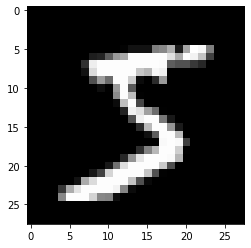

In [2]:
data = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = data.load_data()

print('train_set_images:', train_images.shape, type(train_images[0,0,0]), 
      'min:', np.min(train_images), 'max:', np.max(train_images))
print('train_set_labels:', train_labels.shape,  type(train_labels[0]), 
      'min:', np.min(train_labels), 'max:', np.max(train_labels))

def preprocess_mnist(images, labels):
    print('Preprocessing...')
    #One-hot-encoding of response variables 0-9
    labels = tf.keras.utils.to_categorical(labels)
    
    # Rescaling: uint8(0,255) -> float32(0.0,1.0)
    images = tf.image.convert_image_dtype(images, tf.float32).numpy()
    return images, labels

train_images, train_labels = preprocess_mnist(train_images, train_labels)
test_images, test_labels = preprocess_mnist(test_images, test_labels)

print('train_set_images:', train_images.shape, type(train_images[0,0,0]), 
      'min:', np.min(train_images), 'max:', np.max(train_images))
print('train_set_labels:', train_labels.shape,  type(train_labels[0,0]), 
      'min:', np.min(train_labels), 'max:', np.max(train_labels))

print('\nInspecting the first image and label pair:')
plt.imshow(train_images[0], cmap='gray')
print(train_labels[0])

## A simple convolutional model

We also need a `tf.keras` model to train. Let us just build a simple [convolutional model](https://towardsdatascience.com/convolutional-neural-network-17fb77e76c05) that accepts 28x28x1 images and predicts a vector of length 10.

*Note: If you wonder why the actual model instantiation is done outside of the function this is because we will later reuse the layer configuration, but not the actual `tf.keras.Model` object, when we subclass the `tf.keras.Model` class.*

In [3]:
def simple_conv_model():
    input_layer = tf.keras.Input(shape=(IMAGE_H, IMAGE_W, IMAGE_CHANNELS))
    x = tf.keras.layers.Conv2D(16, 5, activation="relu")(input_layer)
    x = tf.keras.layers.Conv2D(8, 5, activation="relu")(x)
    x = tf.keras.layers.Conv2D(4, 5, activation="relu")(x)
    x = tf.keras.layers.Conv2D(2, 5, activation="relu")(x)
    x = tf.keras.layers.Flatten()(x)
    output_layer = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(x)
    return input_layer, output_layer

input_layer, output_layer = simple_conv_model()
model = tf.keras.Model(input_layer, output_layer)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 16)        416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 8)         3208      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 4)         804       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 2)         202       
_________________________________________________________________
flatten (Flatten)            (None, 288)               0         
_________________________________________________________________
dense (Dense)                (None, 10)               

## Starting matlab.engine

Time to fire up the Matlab Engine! If your [install](https://se.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html) went well this should be a breeze.

In [4]:
def start_matlab():
    print('Starting matlab.engine ...')
    eng = matlab.engine.start_matlab()
    
    # Changing the current working directory of the matlab engine
    # to the directory containing our matlab function .m file
    eng.cd(str(pathlib.Path(MATLAB_METRIC_DIR).resolve()))
    
    # Verifying that the engine has started
    if isinstance(eng, matlab.engine.matlabengine.MatlabEngine):
        print('matlab.engine started')
    return eng
matlab_engine = start_matlab()

Starting matlab.engine ...
matlab.engine started


## Our Matlab function

In order to compare with existing `tf.keras.metrics` our Matlab function is a basic accuracy function. It uses the Matlab internal [confusion](https://se.mathworks.com/help/deeplearning/ref/confusion.html) function. This is probably not the most efficient way of implementing an accuracy function, but it was quick to code.

## The Python/Matlab/TensorFlow metrics functions

There are many ways to code the functions wrapping the `matlab.engine` call to our `accuracy.m` matlab function. This is only one way to do it. We create two functions. `matlab_accuracy` is a pure `tf` function that accepts and returns a tensors. The only job of this function is to use a [tf.py_function](https://www.tensorflow.org/api_docs/python/tf/py_function) to call on the Python `py_matlab_accuracy` function. `py_function` allows us to "step into" *eager execution*, do some work, and return back into *graph execution*. In our case "do some work" means call on our matlab function.

In [5]:
def py_matlab_accuracy(y_true, y_pred):
    # Check that the graph is executing eagerly. It should.
    assert tf.executing_eagerly()
    
    # Since we are running eagerly we can convert tensor to np.ndarray
    y_true, y_pred = y_true.numpy(), y_pred.numpy()
    
    # accuracy.m requires transpose matrices
    y_true, y_pred = np.transpose(y_true), np.transpose(y_pred)
    
    # converting ndarrays to matlab double matrices
    y_true, y_pred = matlab.double(y_true.tolist()), matlab.double(y_pred.tolist())
    
    # calling the matlab function
    metric = matlab_engine.accuracy(y_true, y_pred)
    
    # returning the metric as a tensor
    return tf.constant(metric, tf.float32)

def matlab_accuracy(y_true, y_pred):
    # Notice how we need to define output data type tf.float32
    matlab_metric = tf.py_function(py_matlab_accuracy, [y_true, y_pred], [tf.float32])
    return matlab_metric

## Compile, fit and inspect our Matlab metric

It is time to test our implementation. This is where we get rewarded by the `tf.keras.Model` objects simple API. As can be seen in the code below all that now is required is to pass our `matlab_accuracy` function as a metric in the `compile` method.

Comparing `accuracy` with `matlab_accuracy` we find that their values are, except for minor rounding differences, equal.

In [6]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy', matlab_accuracy])

EPOCHS = 5
history = model.fit(x=train_images, y=train_labels, 
          batch_size=64, epochs = EPOCHS, steps_per_epoch = 200,
          validation_data=(test_images, test_labels))

Epoch 1/5
200/200 [==============================] - 11s 55ms/step - loss: 0.8268 - accuracy: 0.7320 - matlab_accuracy: 0.7320 - val_loss: 0.4116 - val_accuracy: 0.8746 - val_matlab_accuracy: 0.8749
Epoch 2/5
200/200 [==============================] - 12s 60ms/step - loss: 0.3620 - accuracy: 0.8918 - matlab_accuracy: 0.8918 - val_loss: 0.2915 - val_accuracy: 0.9104 - val_matlab_accuracy: 0.9105
Epoch 3/5
200/200 [==============================] - 11s 55ms/step - loss: 0.2778 - accuracy: 0.9162 - matlab_accuracy: 0.9162 - val_loss: 0.2342 - val_accuracy: 0.9290 - val_matlab_accuracy: 0.9290
Epoch 4/5
200/200 [==============================] - 11s 55ms/step - loss: 0.2270 - accuracy: 0.9338 - matlab_accuracy: 0.9338 - val_loss: 0.1837 - val_accuracy: 0.9452 - val_matlab_accuracy: 0.9455
Epoch 5/5
200/200 [==============================] - 10s 52ms/step - loss: 0.2076 - accuracy: 0.9376 - matlab_accuracy: 0.9376 - val_loss: 0.1947 - val_accuracy: 0.9418 - val_matlab_accuracy: 0.9418


## What if you want full control of the metric calculation?

Looping back to my Super-Resolution problem in the introduction I wanted to implement [Ma et al.](https://www.sciencedirect.com/science/article/pii/S107731421630203X)'s Matlab image quality metric, but the calculation of this metric is computationally expensive and due to time limitations I decided I could only afford to run it on the validation images. Such a setup is, to my knowledge, not possible to configure directly in the `tf.keras` API. 

If we still want the benefits of working with `tf.keras.Model` objects what we can do is to write a subclass with customized  `train_step` and `test_step` methods so that the Matlab metric is only calculated when validating/testing.

In [7]:
class CustomModel(tf.keras.Model):
    def __init__(self, *args, **kwargs):
        # Inheriting everything enables normal use of CustomModel
        super(CustomModel, self).__init__(*args, **kwargs)
    
        # Our matlab function and 
        self.matlab_accuracy_fn = None
        self.matlab_accuracy_mean = None
        
    def compile(self, *args, **kwargs):
        # Inheriting everything enables normal use of compile method
        super(CustomModel, self).compile(*args, **kwargs)
        
        # compile() assigns our matlab_accuracy function to the CustomModel object
        self.matlab_accuracy_fn = matlab_accuracy
        
        # Object needed to properly calulate and report a metric
        # within the tf.keras framework:
        self.matlab_accuracy_mean = tf.keras.metrics.Mean(name='matlab_accuracy')
        
    def train_step(self, data):
        super(CustomModel, self).train_step(data)
        
        # Only tweak to train_step is to avoid reporting matlab_accuracy
        # by popping it from the metrics dict before return
        metrics_to_report = {m.name: m.result() for m in self.metrics}
        metrics_to_report.pop(self.matlab_accuracy_mean.name)
        return metrics_to_report

    def test_step(self, data):
        # No inheritance
        x, y = data
        y_pred = self(x, training=False)
        
        # compiled_loss, compiled_metrics allows adding more
        # losses and metrics in the compile method.
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        self.compiled_metrics.update_state(y, y_pred)
        
        # Checks that the graph is static. It should be
        assert not tf.executing_eagerly() 
    
        # The actual matlab call
        matlab_accuracy_value = self.matlab_accuracy_fn(y, y_pred)
        
        # Checks that the graph is static. It should be
        assert not tf.executing_eagerly()
        
        # Update the metric object
        self.matlab_accuracy_mean.update_state(matlab_accuracy_value)
        return {m.name: m.result() for m in self.metrics}
    
    @property
    def metrics(self):
        metrics = super().metrics
        metrics.append(self.matlab_accuracy_mean)
        return metrics

## Build, compile, fit and inspect our Matlab metric

That should be it. Now we need to build a new model, `custom_model` with the same convolutional design as the `model` model, but with the difference being that we instantiate it as a `CustomModel` object.

In [8]:
# Building a CustomModel model
input_layer, output_layer = simple_conv_model()
custom_model = CustomModel(input_layer, output_layer)

# Compiling. Note that matlab_accuracy is not passed as a metric.
custom_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

EPOCHS = 5
history = custom_model.fit(x=train_images, y=train_labels, 
          batch_size=64, epochs = EPOCHS, steps_per_epoch = 200,
          validation_data=(test_images, test_labels))

Epoch 1/5
200/200 [==============================] - 6s 32ms/step - loss: 0.8165 - accuracy: 0.7229 - val_loss: 0.2766 - val_accuracy: 0.9133 - val_matlab_accuracy: 0.9134
Epoch 2/5
200/200 [==============================] - 6s 32ms/step - loss: 0.2491 - accuracy: 0.9202 - val_loss: 0.2025 - val_accuracy: 0.9384 - val_matlab_accuracy: 0.9387
Epoch 3/5
200/200 [==============================] - 5s 27ms/step - loss: 0.2015 - accuracy: 0.9384 - val_loss: 0.1694 - val_accuracy: 0.9482 - val_matlab_accuracy: 0.9484
Epoch 4/5
200/200 [==============================] - 6s 31ms/step - loss: 0.1812 - accuracy: 0.9432 - val_loss: 0.1562 - val_accuracy: 0.9525 - val_matlab_accuracy: 0.9527
Epoch 5/5
200/200 [==============================] - 5s 27ms/step - loss: 0.1615 - accuracy: 0.9514 - val_loss: 0.1278 - val_accuracy: 0.9634 - val_matlab_accuracy: 0.9636


# Conclusion

Make a note on computation time.